In [1]:
import numpy as np
import os
import sys
import torch
import pytorch3d

import matplotlib.pyplot as plt

from pytorch3d.io import load_objs_as_meshes, save_obj
import numpy as np
from tqdm.notebook import tqdm

from src.cube import Cube

from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
)

from src.plot_image_grid import image_grid

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


obj_filename = "./data/bunny.obj"
bunny = load_objs_as_meshes([obj_filename], device=device)

textures=TexturesVertex(verts_features=[torch.ones_like(bunny.verts_packed())])

bunny = Meshes(verts=[bunny.verts_packed()], 
           faces=[bunny.faces_packed()],
           textures=textures)

verts = bunny.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
bunny.offset_verts_(-center)
bunny.scale_verts_((1.0 / float(scale)));

In [12]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 32

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

bunnies = bunny.extend(num_views)

In [13]:
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

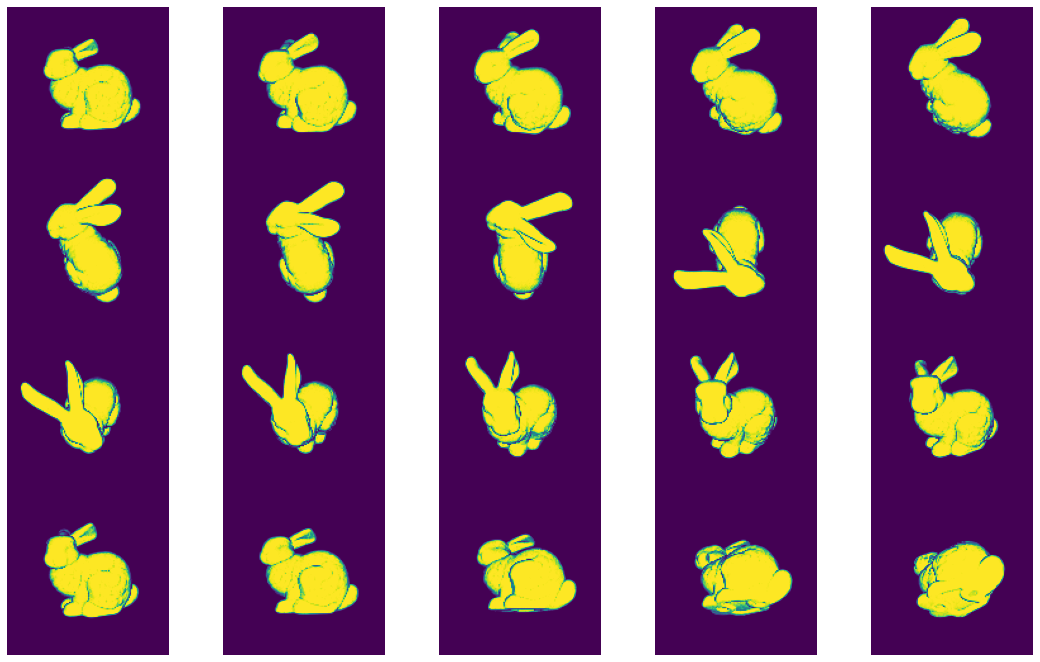

In [33]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(bunnies, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [34]:
n = 16
cube = Cube(n, kernel=5, sigma=2).to(device)

# self.gaussian(p.data.grad)

# clip_value = 0.1
# for p in cube.params.values():
#     #print(p)
#     p.register_hook(lambda grad: print(grad.shape) or torch.clamp(grad, -clip_value, clip_value))
#cube.export(f'./data/cube_mesh{n}.obj')
optimizer = torch.optim.SGD(cube.parameters(), lr=1., momentum=0.9)
#optimizer = torch.optim.Adam(cube.parameters(), lr=0.001)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 1.0
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [36]:
Niter = 10000
num_views_per_iteration = 2

loop = tqdm(range(Niter))

for i in loop:
    stop = False
#    with torch.autograd.detect_anomaly():
    optimizer.zero_grad()

    # Deform the mesh
    #new_src_mesh = src_mesh.offset_verts(torch.sigmoid(deform_verts))
    new_src_mesh = cube.forward()

    sum_loss = torch.tensor(0.0, device=device)
#     sum_loss += mesh_edge_loss(new_src_mesh) * 1.0
#     sum_loss += mesh_normal_consistency(new_src_mesh) * 0.01
#     sum_loss += mesh_laplacian_smoothing(new_src_mesh, method="uniform") * 1.0
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        if not torch.isnan(loss_silhouette):            
            sum_loss += loss_silhouette / num_views_per_iteration            
        else:
            print('singularity', i)
            #for p in cube.params.values():
            #    torch.nan_to_num_(p.data)
            stop = True
    
    if stop:
        print(i)
        cube.export(f'./data/cube_mesh_{n}_{i}.obj')
#         pytorch3d.io.save_ply(f'./data/deformed{i}.ply', 
#             new_src_mesh.verts_packed(),
#             faces=new_src_mesh.faces_packed())
        break
        
    loop.set_description("total_loss = %.6f" % sum_loss)
    if sum_loss > 0:
        sum_loss.backward()        
        optimizer.step()
        
cube.export(f'./data/cube_mesh_{n}.obj')
f'./data/cube_mesh_{n}.obj'

'./data/cube_mesh_8.obj'

In [8]:
cube.export(f'./data/cube_mesh_{n}.obj')
f'./data/cube_mesh_{n}.obj'

'./data/cube_mesh_8.obj'

In [9]:
for p in cube.params.values():
    print(p.abs().max())

tensor(2.1364, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.7691, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.3868, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.7856, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1.5085, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(2.6200, device='cuda:0', grad_fn=<MaxBackward1>)
